# Seq2Seq English-Polish Translation with Attention

Character-level LSTM Encoder-Decoder for translation.

**Architecture:**
- Encoder: LSTM processes English sentence → context vectors (h, c)
- Decoder: LSTM generates Polish translation using context
- Teacher forcing during training
- Autoregressive generation during inference
- 3 different attention mechanism to have fun with

---

## 📋 Setup Instructions for Kaggle

1. **Upload this notebook** to Kaggle
2. **Upload dataset**: Add `eng_to_pl.tsv` as input data
   - Click "Add Data" → "Upload" → Select your `eng_to_pl.tsv` file
   - Or create a Kaggle dataset first, then add it as input
3. **Enable GPU**: Settings → Accelerator → GPU T4 x2 (or P100)
4. **Run all cells**

The notebook will automatically detect if it's running on Kaggle or locally and adjust the data path accordingly.


# Notes on my understanding of the flow.
1. Encoder's role: save and compress as much information from the English sentence into the final hidden state (short term memory) and cell state (a highway - long term memory). We also save encoder states which is encoder's hidden state at each step during looping over characters in source sentences.
2. Decoder then starts from those exact states (hidden and cell from encoder) and retrieves that saved information to generate the translation.
3. During training we compute attention over all encoder states. We saved them, and returned them during encoding step (1). Thanks to attention we can understand which characters in the source sentence (English) are most important for predicting the current next character in the target sentence (Polish)
4. We combine the context_vector returned from attention mechanism with hidden state of Decoder's LSTM. This is the key idea of attention: instead of relying only on the decoder's hidden state (which can forget) you augment it with a fresh, focused summary of the source sentence.
5. We predict next character using output layer (Linear) that we then place inside LogSoftmax. We store each prediction in order to return the list of all predictions.
6. Once we finish looping over the characters of the target sentences inside Decoder, we compute the loss. Then we do a backpropagation, grad clipping and optimizer step.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import csv
from pathlib import Path

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# if torch.backends.mps.is_available():
#     mps_device = torch.device("mps")
#     print("MPS is available and device is set.")
# else:
#     print("MPS is not available.")


Using device: cpu


## 1. Data Loading

Upload your `eng_to_pl.tsv` file to Kaggle's input folder, or adjust the path below.


In [14]:
class EnglishToPolishTranslationData:
    def __init__(self, data_path="/kaggle/input/eng-to-pl/eng_to_pl.tsv"):
        self.pairs = []
        
        if not Path(data_path).exists():
            data_path = "/Users/kamilstaszewski/Projects/math/data/eng_to_pl/eng_to_pl.tsv"  # Local path 
        
        with open(data_path, encoding="utf-8") as tsv_file:
            reader = csv.reader(tsv_file, delimiter="\t")
            for row in reader:
                eng = row[1]
                pol = row[3]
                # Filter for shorter sentences (5-12 chars English, 5-15 chars Polish)
                if len(eng) < 5 or len(eng) > 12:
                    continue
                if len(pol) < 5 or len(pol) > 15:
                    continue
                self.pairs.append((eng.lower(), pol.lower()))
        
        self.build_vocabulary()
        print(f"Loaded {len(self.pairs)} translation pairs")
        print(f"Vocabulary size: {self.vocab_size}")
    
    def build_vocabulary(self):
        all_chars = set().union(*(eng + pol for eng, pol in self.pairs))
        self.chars = sorted(all_chars)

        self.chars = ["<PAD>", "<START>", "<END>"] + self.chars
        
        self.char_to_idx = {ch: i for i, ch in enumerate(self.chars)}
        self.idx_to_char = {i: ch for i, ch in enumerate(self.chars)}
        self.vocab_size = len(self.chars)
    
    def char_to_onehot(self, char):
        """Convert character to one-hot vector (1, vocab_size)"""
        char_idx = self.char_to_idx[char]
        onehot = torch.zeros(1, self.vocab_size, device=device)
        onehot[0, char_idx] = 1
        return onehot
    
    def get_pairs(self):
        return self.pairs

data = EnglishToPolishTranslationData()
print(f"\nFirst 3 pairs:")
for eng, pol in data.get_pairs()[:3]:
    print(f"  '{eng}' → '{pol}'")


Loaded 2723 translation pairs
Vocabulary size: 58

First 3 pairs:
  'hurry up.' → 'pośpiesz się!'
  'so what?' → 'no i co?'
  'so what?' → 'no i?'


## 2. LSTM Encoder

Processes English sentence character-by-character, outputs final hidden & cell states.


In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.lstm_cell = nn.LSTMCell(input_size, hidden_size)
    
    def encode(self, sentence, data_processor):
        hidden = torch.zeros(1, self.hidden_size, device=device)
        cell = torch.zeros(1, self.hidden_size, device=device)
        encoder_states = torch.zeros(len(sentence), self.hidden_size, device=device)
        
        for i, char in enumerate(sentence):
            onehot = data_processor.char_to_onehot(char)
            hidden, cell = self.lstm_cell(onehot, (hidden, cell))
            encoder_states[i] = hidden.squeeze(0)
        
        return encoder_states, hidden, cell


## 3. Attention

In [16]:
class BahdanauAttention(nn.Module):
    def __init__(self, encoder_hidden_size, decoder_hidden_size, attention_size):
        """
        Bahdanau attention mechanism.
        """
        super().__init__()
        
        self.W_encoder = nn.Linear(encoder_hidden_size, attention_size, bias=False)

        self.W_decoder = nn.Linear(decoder_hidden_size, attention_size, bias=False)

        self.v = nn.Linear(attention_size, 1, bias=False)

    def forward(self, decoder_hidden, encoder_states):
        decoder_hidden = decoder_hidden.squeeze(0)  # (hidden,)
        
        # Project encoder states and decoder hidden state to attention space
        encoder_proj = self.W_encoder(encoder_states)  # (seq_len, attention_size)
        decoder_proj = self.W_decoder(decoder_hidden)  # (attention_size,)
        
        combined = torch.tanh(encoder_proj + decoder_proj)  # (seq_len, attention_size)
        
        # Compute alignment scores
        scores = self.v(combined).squeeze(-1)  # (seq_len,)
        
        # Softmax to get attention weights
        attention_weights = F.softmax(scores, dim=0)  # (seq_len,)
        
        # Compute weighted sum of encoder states (context vector)
        context_vector = torch.einsum('s,sh->h', attention_weights, encoder_states)  # (hidden,)
        
        context_vector = context_vector.unsqueeze(0)      # (1, hidden)
        attention_weights = attention_weights.unsqueeze(0)  # (1, seq_len)
        
        return context_vector, attention_weights
        

In [17]:
class CosineAttention(nn.Module):
    """
    Cosine similarity attention mechanism.
    Formula: cosine_sim(a, b) = (a · b) / (||a|| * ||b||)
    """
    def __init__(self):
        super().__init__()

    def forward(self, decoder_hidden, encoder_states):
        decoder_hidden = decoder_hidden.squeeze(0)  # (hidden,)

        # Compute cosine similarity: (a · b) / (||a|| * ||b||)
        numerator = encoder_states @ decoder_hidden  # (seq_len,)
        encoder_norms = torch.norm(encoder_states, dim=1)  # (seq_len,)
        decoder_norm = torch.norm(decoder_hidden)  # scalar

        scores = numerator / (encoder_norms * decoder_norm + 1e-8)  # (seq_len,)

        attention_weights = F.softmax(scores, dim=0)  # (seq_len,)

        context_vector = torch.einsum('s,sh->h', attention_weights, encoder_states)  # (hidden,)
        
        context_vector = context_vector.unsqueeze(0)      # (1, hidden)
        attention_weights = attention_weights.unsqueeze(0)  # (1, seq_len)

        return context_vector, attention_weights


In [18]:
class DotProductAttention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.scale = 1.0 / (hidden_size ** 0.5)  # Scaling factor
    
    def forward(self, decoder_hidden, encoder_states):
        decoder_hidden = decoder_hidden.squeeze(0)  # (hidden,)
        
        scores = encoder_states @ decoder_hidden  # (seq_len,)
        scores = scores * self.scale  # Scale to prevent vanishing gradients
        
        attention_weights = F.softmax(scores, dim=0)  # (seq_len,)
        
        context_vector = torch.einsum('s,sh->h', attention_weights, encoder_states)  # (hidden,)
        
        return context_vector.unsqueeze(0), attention_weights.unsqueeze(0)

## 3. LSTM Decoder

Generates Polish translation using context from encoder.

- **Training mode**: Teacher forcing (uses ground truth as input)
- **Generation mode**: Autoregressive (uses its own predictions)


In [19]:
class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.lstm_cell = nn.LSTMCell(input_size, hidden_size)
        # self.attention = BahdanauAttention(
        #     encoder_hidden_size=hidden_size,
        #     decoder_hidden_size=hidden_size,
        #     attention_size=128  # Can tune this
        # )

        # self.attention = CosineAttention()
        self.attention = DotProductAttention(hidden_size)
        self.output_layer = nn.Linear(hidden_size * 2, output_size)
    
    def predict_char_probs(self, hidden_state):
        logits = self.output_layer(hidden_state)
        log_probs = F.log_softmax(logits, dim=1)
        return log_probs
    
    def decode_train(self, encoder_states, context_h, context_c, target_sentence, data):
        hidden = context_h
        cell = context_c
        predictions = []
        
        current_char = "<START>"
        
        for target_char in target_sentence:
            onehot = data.char_to_onehot(current_char)
            hidden, cell = self.lstm_cell(onehot, (hidden, cell))
            context_vector, _ = self.attention(hidden, encoder_states)
            combined = torch.cat([context_vector, hidden], dim = 1)
            prediction = self.predict_char_probs(combined)
            predictions.append(prediction)
            
            current_char = target_char  # Teacher forcing
        
        # Predict <END> token
        onehot = data.char_to_onehot(current_char)
        hidden, cell = self.lstm_cell(onehot, (hidden, cell))
        context_vector, _ = self.attention(hidden, encoder_states)
        combined = torch.cat([context_vector, hidden], dim = 1)
        prediction = self.predict_char_probs(combined)
        predictions.append(prediction)
        
        return predictions
    
    def decode_generate(self, encoder_states, context_h, context_c, data, max_length=30):
        hidden = context_h
        cell = context_c
        generated = []
        all_attention_weights = []
        
        current_char = "<START>"
        
        for _ in range(max_length):
            onehot = data.char_to_onehot(current_char)
            hidden, cell = self.lstm_cell(onehot, (hidden, cell))
            context_vector, attention_weights = self.attention(hidden, encoder_states)
            all_attention_weights.append(attention_weights)
            combined = torch.cat([context_vector, hidden], dim = 1)
            log_probs = self.predict_char_probs(combined)
            predicted_idx = log_probs.argmax().item()
            next_char = data.idx_to_char[predicted_idx]
            
            if next_char == "<END>" or next_char == "<PAD>":
                break
            
            generated.append(next_char)
            current_char = next_char
        
        return "".join(generated), all_attention_weights


## 4. Loss Function

Negative Log-Likelihood Loss for sequence of predictions.


In [20]:
def compute_sequence_loss(predictions, target_sequence, data_processor):
    total_loss = 0
    
    for prediction, target_char in zip(predictions, target_sequence):
        target_onehot = data_processor.char_to_onehot(target_char)
        target_idx = target_onehot.argmax().item()
        target_tensor = torch.tensor([target_idx], device=device)
        
        loss = F.nll_loss(prediction, target_tensor)
        total_loss += loss
    
    if len(predictions) > len(target_sequence):
        last_prediction = predictions[-1]
        end_onehot = data_processor.char_to_onehot("<END>")
        end_idx = end_onehot.argmax().item()
        end_tensor = torch.tensor([end_idx], device=device)
        
        loss = F.nll_loss(last_prediction, end_tensor)
        total_loss += loss
    
    avg_loss = total_loss / len(predictions)
    return avg_loss


## 5. Training Loop

Train encoder and decoder jointly with backpropagation through time.


In [21]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_attention(input_sentence, output_sentence, attention_weights):
    """
    Visualize attention weights as a heatmap.
    
    Args:
        input_sentence: English input string
        output_sentence: Polish output string
        attention_weights: List of attention weight arrays, shape (1, input_len) each
    """
    # Convert attention weights to 2D array: (output_len, input_len)
    attention_matrix = np.vstack([w.squeeze() for w in attention_weights])
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Create heatmap
    im = ax.imshow(attention_matrix, cmap='YlOrRd', aspect='auto')
    
    # Set ticks and labels
    ax.set_xticks(np.arange(len(input_sentence)))
    ax.set_yticks(np.arange(len(output_sentence)))
    ax.set_xticklabels(list(input_sentence), fontsize=12)
    ax.set_yticklabels(list(output_sentence), fontsize=12)
    
    # Rotate x labels for better readability
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center")
    
    # Labels and title
    ax.set_xlabel('Input (English)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Output (Polish)', fontsize=14, fontweight='bold')
    ax.set_title(f'Attention Weights: "{input_sentence}" → "{output_sentence}"', 
                 fontsize=16, fontweight='bold', pad=20)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Attention Weight', rotation=270, labelpad=20, fontsize=12)
    
    # Add grid for better readability
    ax.set_xticks(np.arange(len(input_sentence)) - 0.5, minor=True)
    ax.set_yticks(np.arange(len(output_sentence)) - 0.5, minor=True)
    ax.grid(which="minor", color="gray", linestyle='-', linewidth=0.5, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [22]:
def test_translation(encoder, decoder, data, test_sentences=None):
    if test_sentences is None:
        test_sentences = ["i love you", "have fun", "why me?"]
    
    encoder.eval()
    decoder.eval()
    
    with torch.no_grad():
        for english in test_sentences:
            encoder_states, context_h, context_c = encoder.encode(english, data)
            polish, attention_weights = decoder.decode_generate(encoder_states, context_h, context_c, data, max_length=30)
            print(f"  {english} → {polish}")

            # uncomment for heatmap
            if len(attention_weights) > 0:
                visualize_attention(english, polish, attention_weights)
    
    encoder.train()
    decoder.train()


def train_network(epochs=200, lr=0.01, max_pairs=2723):
    pairs = data.get_pairs()[:max_pairs]
    print(f"\nTraining on {len(pairs)} pairs\n")
    
    encoder = Encoder(input_size=data.vocab_size, hidden_size=256).to(device)
    decoder = Decoder(input_size=data.vocab_size, hidden_size=256, output_size=data.vocab_size).to(device)
    
    optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)
    
    for epoch in range(epochs):
        epoch_loss = 0
        
        for english, polish in pairs:
            optimizer.zero_grad()
            
            encoder_states, context_h, context_c = encoder.encode(english, data)
            
            predictions = decoder.decode_train(encoder_states, context_h, context_c, polish, data)
            
            loss = compute_sequence_loss(predictions, polish, data)
            epoch_loss += loss.item()
            
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(
            list(encoder.parameters()) + list(decoder.parameters()),
            max_norm=1.0
        )
            
            optimizer.step()
        
        if epoch % 10 == 0:
            avg_loss = epoch_loss / len(pairs)
            print(f"Epoch {epoch}/{epochs}, Loss: {avg_loss:.4f}")
            test_translation(encoder, decoder, data)
            print()
    
    print("Training complete!")
    return encoder, decoder


## 6. Train the Model



Training on 1000 pairs

init 58 256
Epoch 0/100, Loss: 2.7778
  i love you → po ze zaj.


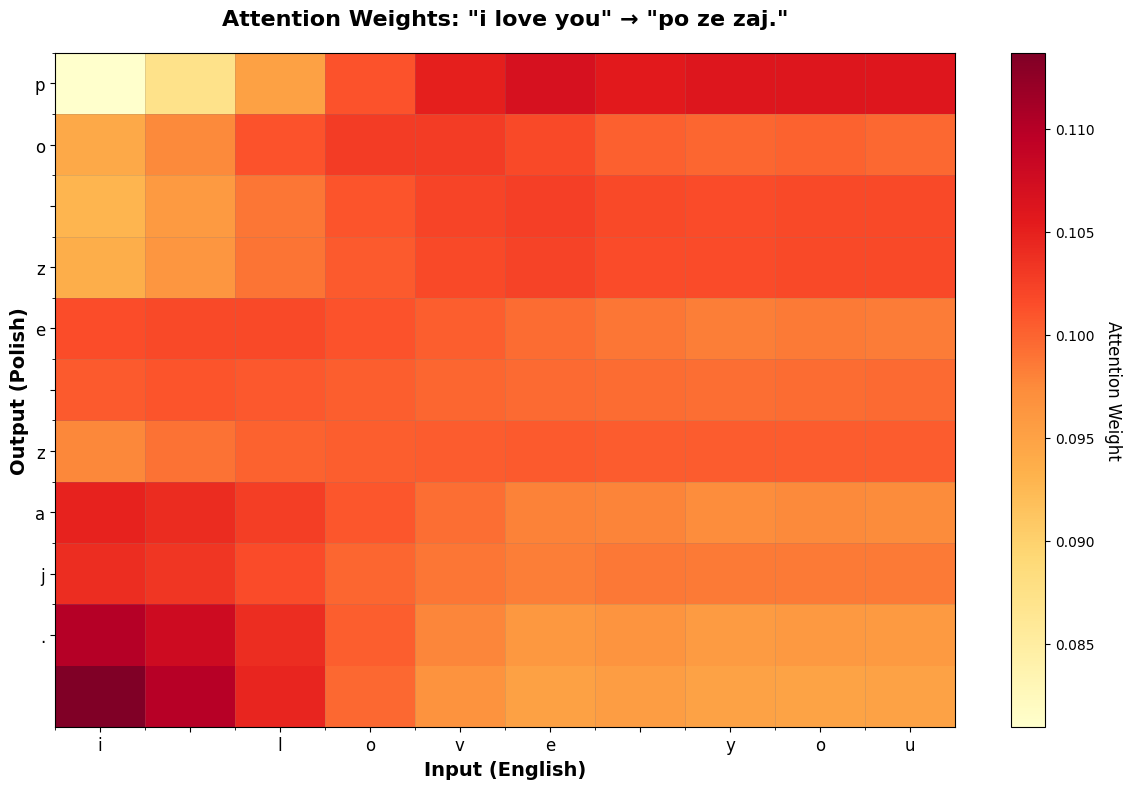

  have fun → po ze zaj.


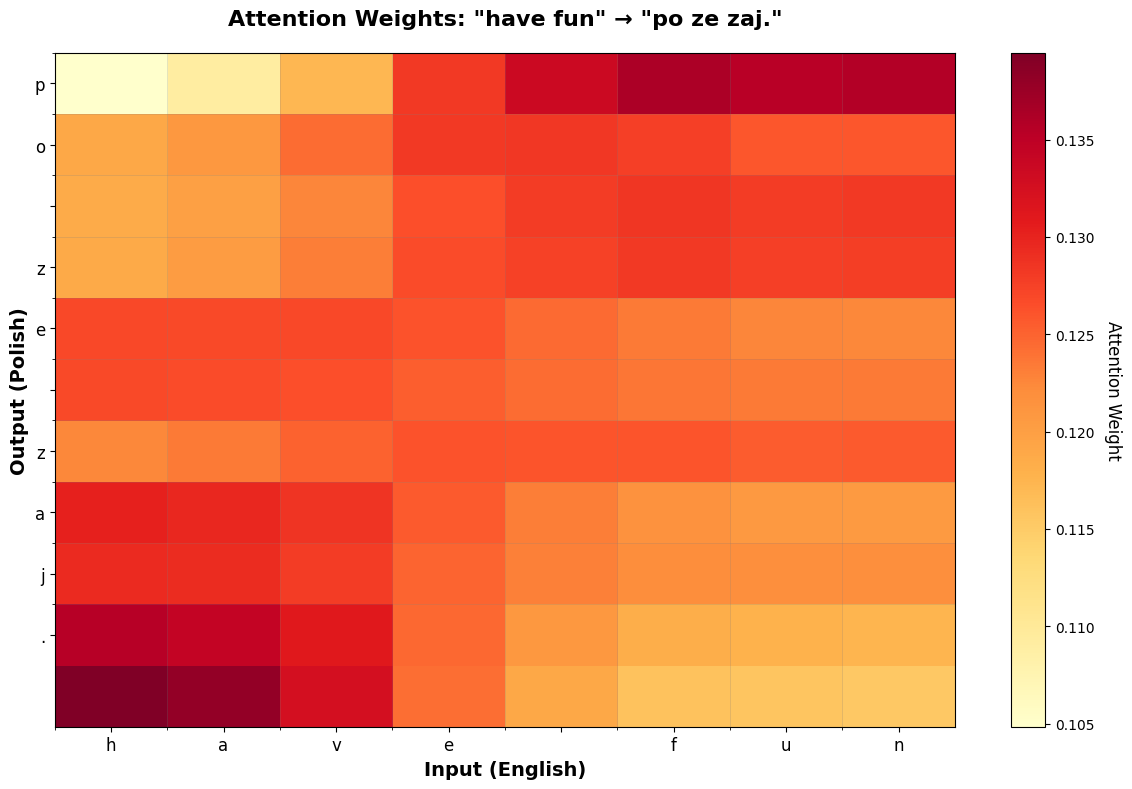

  why me? → po ze zaj.


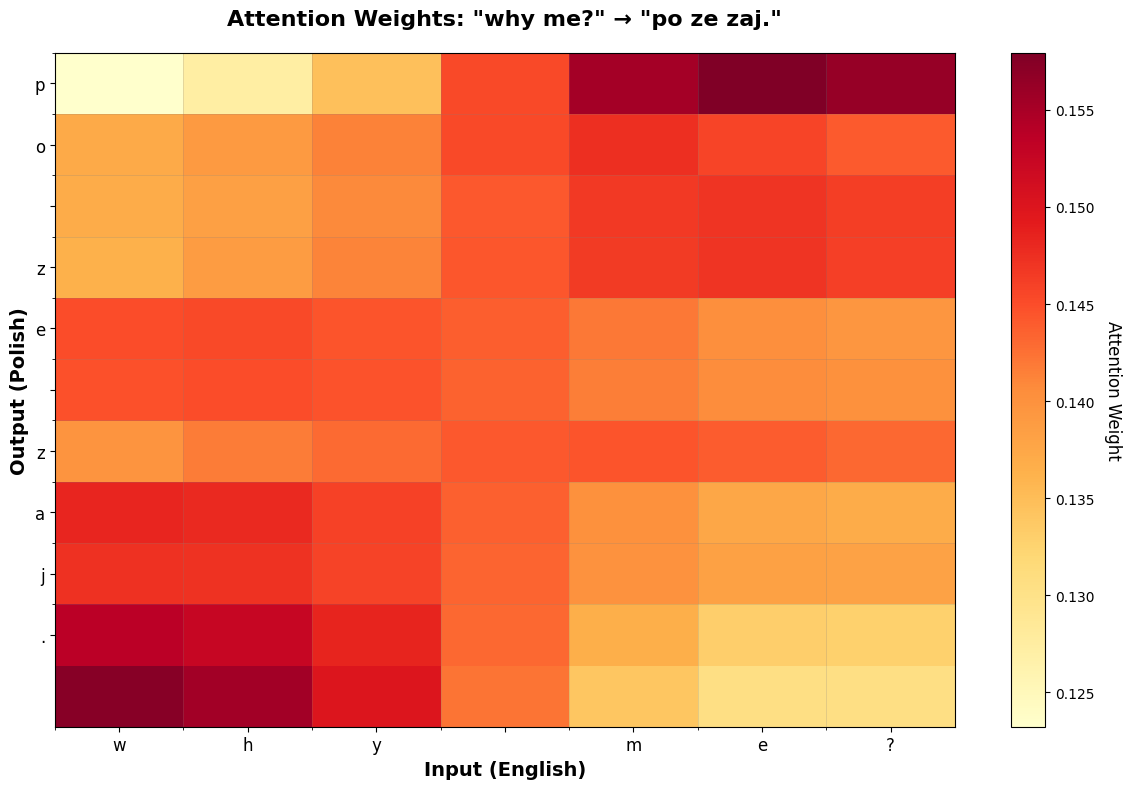

KeyboardInterrupt: 

In [23]:
encoder, decoder = train_network(epochs=100, lr=0.01, max_pairs=1000)


## 7. Test on Custom Sentences


In [ ]:

custom_sentences = [
    "i love you",
    "have fun",
    "why me?",
    "hello",
    "good night"
]

print("\nCustom translations:")
test_translation(encoder, decoder, data, custom_sentences)



Custom translations:
  i love you → kocham cię!
  have fun → obudź się.
  why me? → dlaczego namau.
  hello → pomocy!
  good night → dobranoc.


## 8. Save Models (Optional)


In [ ]:

torch.save({
    'encoder_state_dict': encoder.state_dict(),
    'decoder_state_dict': decoder.state_dict(),
    'vocab_size': data.vocab_size,
    'char_to_idx': data.char_to_idx,
    'idx_to_char': data.idx_to_char
}, 'seq2seq_eng_pol.pth')

print("Models saved to 'seq2seq_eng_pol.pth'")


Models saved to 'seq2seq_eng_pol.pth'


## 9. Load Models (Optional)


In [ ]:

checkpoint = torch.load('seq2seq_eng_pol.pth')


loaded_encoder = Encoder(input_size=checkpoint['vocab_size'], hidden_size=256).to(device)
loaded_decoder = Decoder(input_size=checkpoint['vocab_size'], hidden_size=256, output_size=checkpoint['vocab_size']).to(device)


loaded_encoder.load_state_dict(checkpoint['encoder_state_dict'])
loaded_decoder.load_state_dict(checkpoint['decoder_state_dict'])

data.char_to_idx = checkpoint['char_to_idx']
data.idx_to_char = checkpoint['idx_to_char']

print("Models loaded successfully!")
test_translation(loaded_encoder, loaded_decoder, data)


Models loaded successfully!
  i love you → kocham cię!
  have fun → obudź się.
  why me? → dlaczego namau.
